# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = [X_train.shape[1], X_train.shape[2]]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


In [3]:
import os
import csv
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
# Allow image embeding in notebook
%matplotlib inline

print('All modules imported.')

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False


All modules imported.


['ClassId', 'SignName']
['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']
['5', 'Speed limit (80km/h)']
['6', 'End of speed limit (80km/h)']
['7', 'Speed limit (100km/h)']
['8', 'Speed limit (120km/h)']
['9', 'No passing']
['10', 'No passing for vechiles over 3.5 metric tons']
['11', 'Right-of-way at the next intersection']
['12', 'Priority road']
['13', 'Yield']
['14', 'Stop']
['15', 'No vechiles']
['16', 'Vechiles over 3.5 metric tons prohibited']
['17', 'No entry']
['18', 'General caution']
['19', 'Dangerous curve to the left']
['20', 'Dangerous curve to the right']
['21', 'Double curve']
['22', 'Bumpy road']
['23', 'Slippery road']
['24', 'Road narrows on the right']
['25', 'Road work']
['26', 'Traffic signals']
['27', 'Pedestrians']
['28', 'Children crossing']
['29', 'Bicycles crossing']
['30', 'Beware of ice/snow']
['31', 'Wild animals crossing']
['32', 'End of all speed and passin

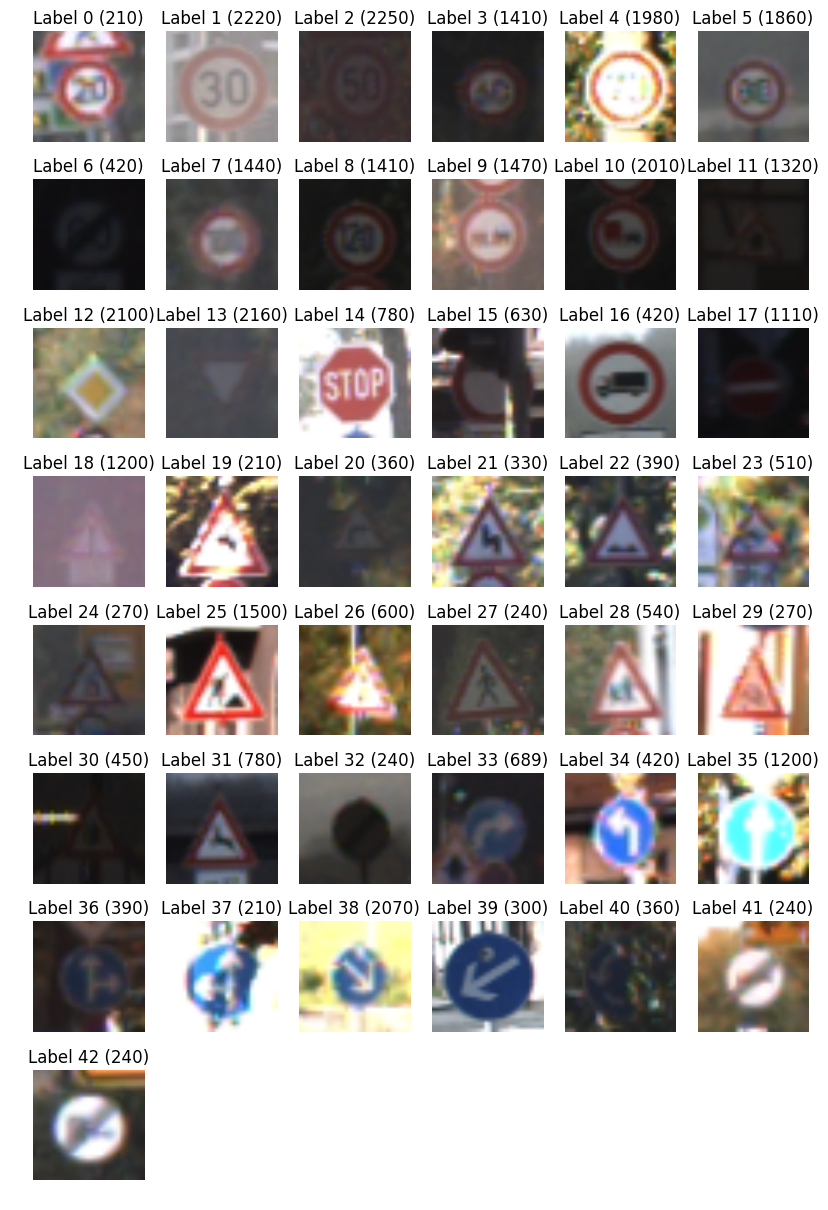

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
with open( './signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        print(line)
f.close() 

print("Top 5 labels in training dataset = ", Counter(y_train).most_common(5))
print("Top 5 labels in testing dataset = " , Counter(y_test).most_common(5))

index = 1
plt.figure(figsize=(10, 15))
for label in range(n_classes):
    image = X_train[y_train.tolist().index(label)]
    plt.subplot(8, 6, index)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(label, y_train.tolist().count(label)))
    index += 1
    plt.imshow(image)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

(32, 32)


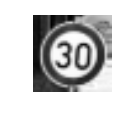

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def rgb2gray(X_rgb, n):
    """
    :return: gray image
    """
    X_gray = np.zeros(X_rgb.shape[0:3])
    for i in range(n):
        X_gray[i] = cv2.cvtColor(X_rgb[i], cv2.COLOR_RGB2GRAY)
    return X_gray
    
    
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

X_train_gray = rgb2gray(X_train, n_train)
X_test_gray = rgb2gray(X_test, n_test)

if not is_features_normal:
    train_features  = normalize_grayscale(X_train_gray)
    test_features  = normalize_grayscale(X_test_gray)
    is_features_normal = True

plt.figure(figsize = (1,1))
plt.axis('off')
plt.imshow(train_features[2000], cmap='Greys_r')
print(train_features[2000].shape)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
1. RGB image to gray image. The reason to use graysclae image is that the color does not matter too much when we trying to classify traffic signs. For example, the "STOP" sign we want to recgonize the letters, and for speed limit we want to know the limit numbers and we really do not care about it is red, green or blue. So it means we do not benefit much by using color image. And color image consumes more parameters for each RGB channle (e.g. 32 x 32 x 3) but grayscale image just have one channel (32 x 32 x 1), so we can choose greyscale image to avoid overfitting and get better training performance. 
2. Normailize these gray images. I implement normalization because according to the lecture "Normalized Inputs and Initial Weights", we always want our variables have zero mean and equal variance to make it a lot easier for the optimizer to do the work. And in practice, a neural network works best if the inputs are centered and white. That means that their covariance is diagonal and the mean is the zero vector. It is only because the optimisation of the neural net works more gracefully, since the hidden activation functions don't saturate that fast and thus do not give you near zero gradients early on in learning. For the normalization range I choose the value 0.1 ~ 0.9 which is based on "CarND-TensorFlow-Lab" code, small inputs will typically require larger weights, and small weights for large inputs. We want to choose a good learning rate and initialized weights so we don't want to input be too small or too large and 0.1/0.9 is a good choice. 

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    train_labels = encoder.transform(y_train)
    test_labels = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [84]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.20,
    random_state=832289)

n_train = len(train_features)
n_valid = len(valid_features)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
1. I use "train_test_split" from sklearn library to generate some validation dataset from training dataset. The validation dataset comes from 20% randomly picked date of the traninning data. Accprding to my experience and "Pareto principle", it is a good staring point to split training dataset into 80%/20% for training and validation. With less training data, your parameter estimates have greater variance. With less testing data, your performance statistic will have greater variance. Broadly speaking you should be concerned with dividing data such that neither variance is too high, which is more to do with the absolute number of instances in each category rather than the percentage. And I tried to randomly sample 30%, 40%, 50% of the training set as validation set but the overall performance does not improved or even worse. So I choose 20% from training set as validation dataset finally.
2. No, I did not generated additional data.

In [8]:
# Save the data for easy access
pickle_file = 'TrafficSign.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('TrafficSign.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [9]:
%matplotlib inline

# Load the modules
import pickle
import math
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = './TrafficSign.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')
print('Training set', train_features.shape, train_labels.shape)
print('Validation set', valid_features.shape, valid_labels.shape)
print('Test set', test_features.shape, test_labels.shape)

Data and modules loaded.
Training set (37248, 32, 32) (37248, 43)
Validation set (1961, 32, 32) (1961, 43)
Test set (12630, 32, 32) (12630, 43)


In [10]:
def reformat(dataset):
  dataset = dataset.reshape((-1, train_features.shape[1], train_features.shape[2], 1)).astype(np.float32)
  return dataset
train_features = reformat(train_features)
valid_features = reformat(valid_features)
test_features = reformat(test_features)

print('Training set', train_features.shape, train_labels.shape)
print('Validation set', valid_features.shape, valid_labels.shape)
print('Test set', test_features.shape, test_labels.shape)

Training set (37248, 32, 32, 1) (37248, 43)
Validation set (1961, 32, 32, 1) (1961, 43)
Test set (12630, 32, 32, 1) (12630, 43)


In [30]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

image_size = train_features.shape[1]
num_labels = train_labels.shape[1]
num_channels = 1 # grayscale

batch_size = 32
learning_rate = 0.1
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_features)
  tf_test_dataset = tf.constant(test_features)  
    
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
     
    
    
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The final architeccture is a convolutional netural network. Batch size = 32, and it contains 4 layers: 
1. layer1 conv1 + relu1 (input size = [32, 32, 32, 1], filter size = [5, 5, 1, 16], stride = 2, padding type = "SAME", output size = [32, 16, 16, 16]) 
2. layer1 conv2+ relu2 (input size = [32, 16, 16, 16], filter size = [5, 5, 16, 16], stride = 2, padding type = "SAME", output size = [32, 8, 8, 16]) 
3. layer3 fully connection layer1 (reshape) + relu3 (input size = [32, 8, 8, 16], shape = [32, 8x8x16], output size = [32, 1024])
4. layer4 fully connection layer2 (input size = [32, 1024], output size = [32, 43])

In [31]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Initialized
Minibatch loss at step 0: 5.552186
Minibatch accuracy: 0.0%
Validation accuracy: 1.8%
Minibatch loss at step 200: 3.011738
Minibatch accuracy: 15.6%
Validation accuracy: 13.8%
Minibatch loss at step 400: 2.053593
Minibatch accuracy: 43.8%
Validation accuracy: 50.5%
Minibatch loss at step 600: 1.555968
Minibatch accuracy: 59.4%
Validation accuracy: 65.7%
Minibatch loss at step 800: 0.843966
Minibatch accuracy: 78.1%
Validation accuracy: 74.6%
Minibatch loss at step 1000: 0.566647
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 0: 0.184230
Minibatch accuracy: 96.9%
Validation accuracy: 82.7%
Minibatch loss at step 200: 0.696840
Minibatch accuracy: 87.5%
Validation accuracy: 82.4%
Minibatch loss at step 400: 0.493543
Minibatch accuracy: 87.5%
Validation accuracy: 86.4%
Minibatch loss at step 600: 0.674285
Minibatch accuracy: 81.2%
Validation accuracy: 88.7%
Minibatch loss at step 800: 0.383064
Minibatch accuracy: 87.5%
Validation accuracy: 90.4%
Min

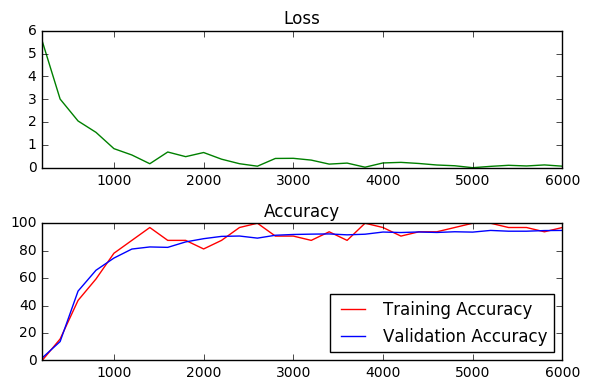

In [32]:
### Train your model here.
### Feel free to use as many code cells as needed.

# ToDo: Find the best parameters for each configuration
epochs = 5
num_steps = train_labels.shape[0] // batch_size

log_batch_step = 200
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

sess = tf.InteractiveSession(graph = graph)
# Create an operation that initializes all variables
init = tf.initialize_all_variables()
sess.run(init)
print('Initialized')
for epoch_i in range(epochs):
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)   
        batch_data = train_features[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        # Log every 200 batches
        if (step % log_batch_step == 0):
            training_accuracy = accuracy(predictions, batch_labels)
            validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % training_accuracy)
            print('Validation accuracy: %.1f%%' % validation_accuracy)
print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 100.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

1. Optimizer: GradientDescentOptimizer
2. Batch size: 32
3. Epochs: 5
4. Learning rate: 0.01
5. Print log infomation every 200 batches

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
1. First, I seperated the dataset to training, validation and testing dataset, and then did preprocess for all the dataset.
2. The next step is to define the neural network architeccture, I use a simple convolutional network to abstract features and do classification. The advantage of using convolutional neural network is that it can abstract features very deeply. Their function is to extract features from their input. These features are then given to the next hidden layer to extract still more complex features, or are directly given to a standard classifier to output the final prediction. Here is some useful references from http://neuralnetworksanddeeplearning.com/chap6.html
    (1) Local receptive fields: We'll connect the input pixels to a layer of hidden neurons. But we won't connect every input pixel to every hidden neuron. Instead, we only make connections in small, localized regions of the input image. That region in the input image is called the local receptive field for the hidden neuron. It's a little window on the input pixels. Each connection learns a weight. And the hidden neuron learns an overall bias as well. You can think of that particular hidden neuron as learning to analyze its particular local receptive field.
    (2) Shared weights and biases: A big advantage of sharing weights and biases is that it greatly reduces the number of parameters involved in a convolutional network. For each feature map we need 25=5×5 shared weights, plus a single shared bias. So each feature map requires 2626 parameters. If we have 2020 feature maps that's a total of 20×26=520 parameters defining the convolutional layer. By comparison, suppose we had a fully connected first layer, with 784=28×28 input neurons, and a relatively modest 3030 hidden neurons, as we used in many of the examples earlier in the book. That's a total of 784×30784×30 weights, plus an extra 3030 biases, for a total of 23,55023,550 parameters. In other words, the fully-connected layer would have more than 4040 times as many parameters as the convolutional layer.
    (3) Pooling layers: In addition to the convolutional layers just described, convolutional neural networks also contain pooling layers. Pooling layers are usually used immediately after convolutional layers. What the pooling layers do is simplify the information in the output from the convolutional layer.

3. Then I use training set to train the module, and tuning parameter during the training procedure to ensure better result.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

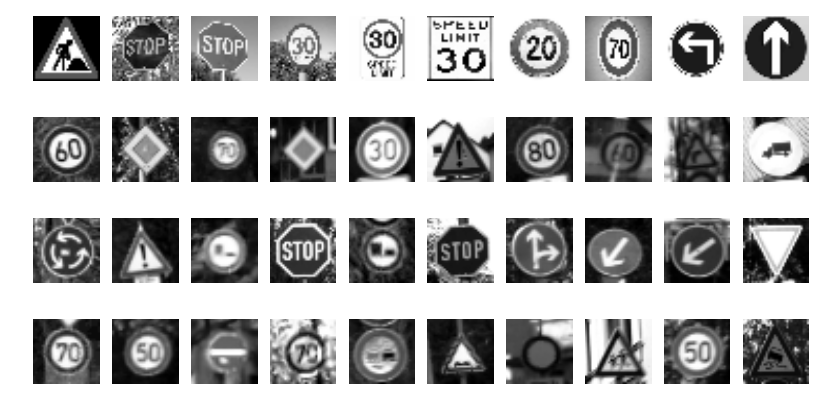

In [113]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def normalize_img(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )


def load_image(filename):
    img = cv2.imread(filename, 0)   
    img = cv2.resize(img, (image_size, image_size))
    img = normalize_img(img)
    return img.astype(np.float32)

img_num = 40
img_num_web = 10
img_num_training = 10
img_num_validation = 10
img_num_testing = 10


imgs = np.zeros([img_num, image_size, image_size])
for i in range(img_num_web):
    filename = './data/test' + str(i) + '.jpg'
    img = load_image(filename)
    imgs[i] = img
    
for i in range(10, 20):
    index = np.random.randint(n_train, size = 1)
    imgs[i] = train_features[index].reshape((-1, image_size, image_size)).astype(np.float32)

for i in range(20, 30):
    index = np.random.randint(n_valid, size = 1)
    imgs[i] = valid_features[index].reshape((-1, image_size, image_size)).astype(np.float32)
    
for i in range(30, 40):
    index = np.random.randint(n_test, size = 1)
    imgs[i] = test_features[index].reshape((-1, image_size, image_size)).astype(np.float32)

prediction_features = reformat(imgs)

plt.figure(figsize=(10, 5))
for i in range(img_num):
    plt.subplot(img_num // 10, 10, i + 1)
    plt.axis('off')
    plt.imshow(imgs[i], cmap='Greys_r')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
If the image has significant difference from the training data, such as pose, position, lighting condition, color, etc, it will be very hard for the network to classify it correctly.
1. Image 1: Road work. This one is very clear and similar to what we have in training data, so it should not be difficult to classify.
2. Image 2,3: Stop sign. This sign contains background and it is slightly tilt. So I would like to double check if the model has pose invariance. 
3. Image 4,5,6: Speed limit 30. All of the three images are not standard one, image 4 has some background and letters below the "30", and as well as the image 5. The image 6 is totally different one, which is what I can see in my daily life but not in the training dataset. So there are some noise more or less, it is a great point to verify the performance.
4. Image 7: Speed limit 20. 
5. Image 8: Speed limit 70. Image 7 and 8 also have some similar features, which is "20" and "70" may be difficlut to distinguish from each other.
6. Image 9: Turn left ahead. The classifier may be confused by this one, comparing to "Double curve" which looks a little bit similar in 32 x 32 scale/
7. Image 10: Ahead only. This one is another standard one and should be a easy one.
8. Image 11 - 20: data from training set
9. Image 21 - 30: data from validation set
10. Image 31 - 40: data from testing set

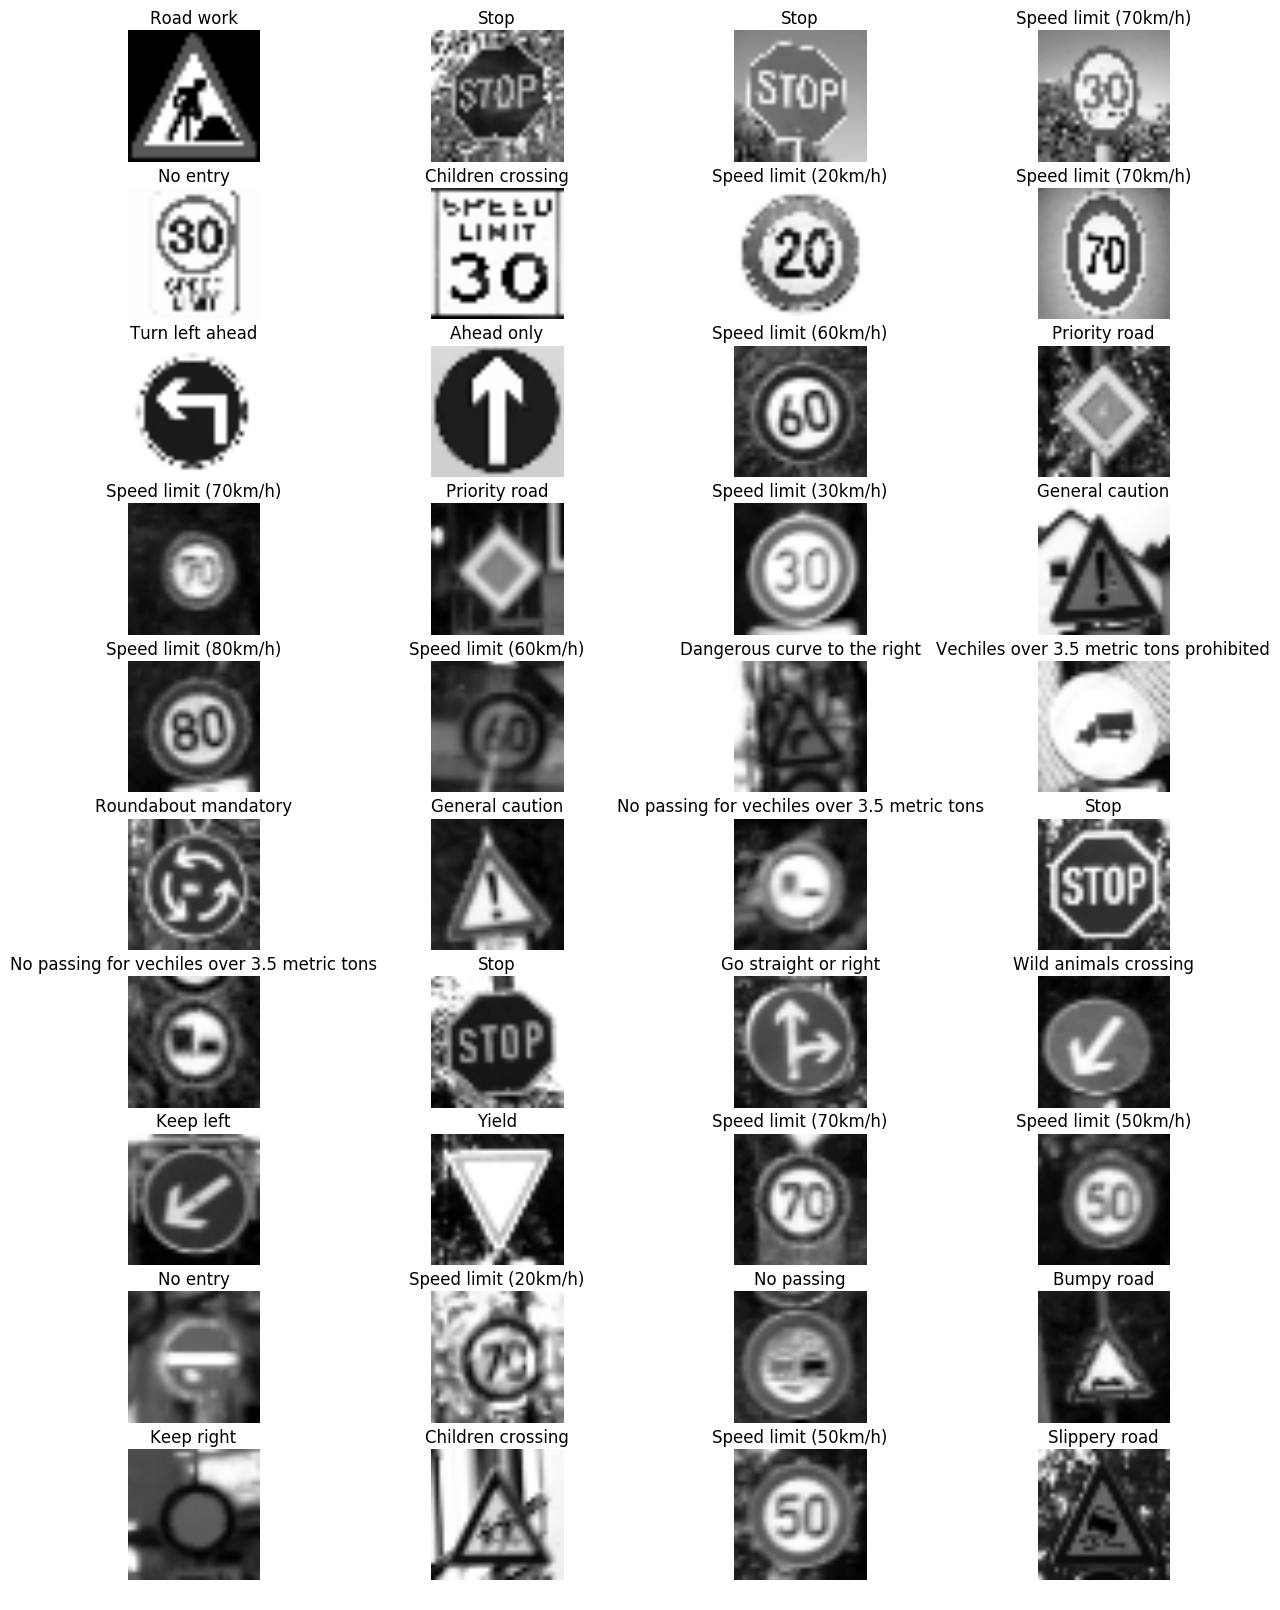

In [118]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

tf_prediction_dataset = tf.constant(prediction_features)
new_prediction = tf.arg_max(tf.nn.softmax(model(tf_prediction_dataset)), 1)
prediction = new_prediction.eval()

plt.figure(figsize=(15, 20))
label_name = []
with open( './signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    label_name = list(reader)
    
    for i in range(img_num):
        plt.subplot(img_num // 4, 4, i + 1)
        plt.axis('off')
        plt.title(label_name[prediction[i] + 1][1])
        plt.imshow(imgs[i], cmap='Greys_r')
f.close() 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
1. Yes, the trained model is able to provide reasonable prediction of new images. Based on the subsample from dataset:
    (1) Accurary from training dataset: 10/10 = 100%
    (2) Accurary from validation dataset: 9/10 = 90%
    (3) Accurary from testing dataset: 8/10 = 80%
    (4) Accurary from online dataset: 7/10 = 70%
2. I can use the "30mph" classification as an expamle. I tried 3 diffrent "30 mph" speed limit sign. The first one is the nomal one, and the neural network is able to classify it successfully. For the second one, the "30" is not in the middle of the image, and there is a "speed limit" label below it. And the third one is totally different one from what we trained before. So the network cannot classfiy them correctly.
3. It means the netural network still have some limitations. First of all, your training data should contains different types, lighting condtions and scenarios. Secondly, you should define the bounding box if you want to use it in real videos. 
5. I also tried some other dataset, and I found the classifier always have the similar confusions. For example, mess up "20" and "70", "30" and "80". And for some traffic sign with little training data, e.g. ['29', 'Bicycles crossing'] with only 270 example, it will have a very hign chance to get wrong prediction.
6. So in order to get better performance, I should train a more complex convlutional neural network, and use more and more data to train it, and tuning the training parameters as well.


In [120]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

k = 5
tf_topk_dataset = tf.constant(prediction_features)
topk_labels = tf.nn.top_k(tf.nn.softmax(model(tf_topk_dataset)), k = k)
result = sess.run(topk_labels)
for i in range(img_num):
    print("image", i + 1)
    for j in range(k):
        print(label_name[result.indices[i][j] + 1], "\t\t " ,result.values[i][j])

image 1
['25', 'Road work'] 		  0.776268
['20', 'Dangerous curve to the right'] 		  0.170669
['23', 'Slippery road'] 		  0.0522658
['18', 'General caution'] 		  0.000427037
['6', 'End of speed limit (80km/h)'] 		  0.000228131
image 2
['14', 'Stop'] 		  0.898851
['13', 'Yield'] 		  0.100976
['15', 'No vechiles'] 		  7.51639e-05
['9', 'No passing'] 		  6.177e-05
['12', 'Priority road'] 		  2.18223e-05
image 3
['14', 'Stop'] 		  0.994995
['12', 'Priority road'] 		  0.00447049
['15', 'No vechiles'] 		  0.000301508
['9', 'No passing'] 		  9.78285e-05
['3', 'Speed limit (60km/h)'] 		  9.62179e-05
image 4
['4', 'Speed limit (70km/h)'] 		  0.505001
['0', 'Speed limit (20km/h)'] 		  0.269268
['1', 'Speed limit (30km/h)'] 		  0.127664
['5', 'Speed limit (80km/h)'] 		  0.0980295
['32', 'End of all speed and passing limits'] 		  1.90913e-05
image 5
['17', 'No entry'] 		  0.999058
['18', 'General caution'] 		  0.000757934
['39', 'Keep left'] 		  0.000171145
['22', 'Bumpy road'] 		  1.06823e-05
['26

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
1. Generally speaking, for the data from training set and validation set, the model has very high confidence with most of the signs, and for testing set the certainty is a little bit lower but still on a high level. 
    (1)The model is uncertain about the sign of speed limit, for example the difference of number "20" "30" and "70". It is mainly because these numbers has similarity, and there are some noise from background, light, pose, scale, orientation, etc... In additional, some traffic sign with limited number of training data may be took for ohter signs, such as ['End of no passing'] and ['End of no passing by vechiles over 3.5 metric tons']
    (2)It has extraordinary certain of arrows and sign of letters such as "STOP" sign, which contains obvious feature on the traffic sign. And for the rest of the sign, the model still have high accuracy.
2. Sometimes it provides wrong classification, but the right one still has the top 5 possibility, so maybe we need more data and tuning the parameters to get more accuracy result.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
The images are loadad by opencv "imread" in greyscale, and then I did some preprocess such as resize and image normailization to get better performance.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [121]:
sess.close()